In [27]:
import tensorflow_hub as hub
import tensorflow_text
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from tensorflow import keras


In [2]:
# load universal sent encoder model
# use = hub.load("https://tfhub.dev/google/universal-sentence-encoder-multilingual-large/3")
# or load downloaded model from local
use = hub.load(r'models\universal-sentence-encoder-multilingual-large_3')

In [3]:
sent_1 = ['Dell is a computer company']
sent_2 = ['HP is a computer company']
emb_1 = use(sent_1)
emb_2 = use(sent_2)

In [4]:
print(np.inner(emb_1, emb_2).flatten()[0])

0.6224514


In [37]:
# Data downloaded form kaggle - https://www.kaggle.com/datasets/jiashenliu/515k-hotel-reviews-data-in-europe
df = pd.read_csv("data/Hotel_Reviews.csv", parse_dates=['Review_Date'], nrows=5000)

In [38]:
df.head()

,Hotel_Address,Additional_Number_of_Scoring,Review_Date,Average_Score,Hotel_Name,Reviewer_Nationality,Negative_Review,Review_Total_Negative_Word_Counts,Total_Number_of_Reviews,Positive_Review,Review_Total_Positive_Word_Counts,Total_Number_of_Reviews_Reviewer_Has_Given,Reviewer_Score,Tags,days_since_review,lat,lng
0,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,2017-08-03,7.7,Hotel Arena,Russia,I am so angry that i made this post available...,397,1403,Only the park outside of the hotel was beauti...,11,7,2.9,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
1,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,2017-08-03,7.7,Hotel Arena,Ireland,No Negative,0,1403,No real complaints the hotel was great great ...,105,7,7.5,"[' Leisure trip ', ' Couple ', ' Duplex Double...",0 days,52.360576,4.915968
2,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,2017-07-31,7.7,Hotel Arena,Australia,Rooms are nice but for elderly a bit difficul...,42,1403,Location was good and staff were ok It is cut...,21,9,7.1,"[' Leisure trip ', ' Family with young childre...",3 days,52.360576,4.915968
3,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,2017-07-31,7.7,Hotel Arena,United Kingdom,My room was dirty and I was afraid to walk ba...,210,1403,Great location in nice surroundings the bar a...,26,1,3.8,"[' Leisure trip ', ' Solo traveler ', ' Duplex...",3 days,52.360576,4.915968
4,s Gravesandestraat 55 Oost 1092 AA Amsterdam ...,194,2017-07-24,7.7,Hotel Arena,New Zealand,You When I booked with your company on line y...,140,1403,Amazing location and building Romantic setting,8,3,6.7,"[' Leisure trip ', ' Couple ', ' Suite ', ' St...",10 days,52.360576,4.915968


In [39]:
df['review'] = df['Negative_Review'] + df['Positive_Review']

In [40]:
df['review_type'] = df['Reviewer_Score'].apply(lambda x: 'bad' if x<7 else 'good')
df = df[['review', 'review_type']]

In [41]:
df.review_type.value_counts()

good    3965
bad     1035
Name: review_type, dtype: int64

Text(0.5, 1.0, 'Review Type')

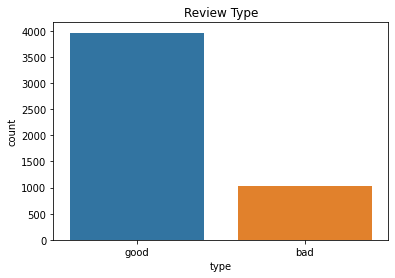

In [42]:
sns.countplot(x='review_type', data=df, order=df.review_type.value_counts().index)
plt.xlabel('type')
plt.title('Review Type')

In [43]:
good_reviews = df[df.review_type=='good']
bad_reviews = df[df.review_type=='bad']

In [44]:
print(good_reviews.shape, bad_reviews.shape)

(3965, 2) (1035, 2)


In [45]:
good_reviews_text = " ".join(good_reviews.review.to_numpy().tolist())
bad_reviews_text = " ".join(bad_reviews.review.to_numpy().tolist())

good_reviews_cloud = WordCloud(stopwords=STOPWORDS, background_color="white").generate(good_reviews_text)
bad_reviews_cloud = WordCloud(stopwords=STOPWORDS, background_color="white").generate(bad_reviews_text)

In [46]:
def show_word_cloud(cloud, title):
    plt.figure(figsize=(16, 10))
    plt.imshow(cloud, interpolation='bilinear')
    plt.title(title)
    plt.axis('off')
    plt.show()

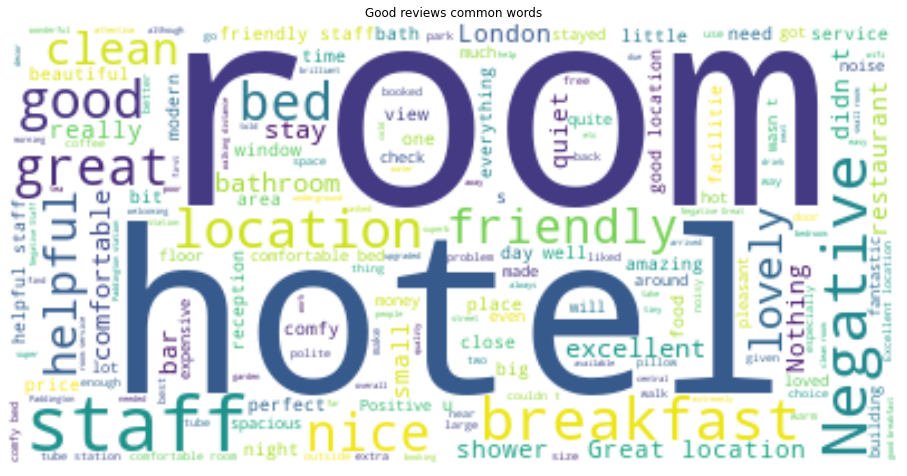

In [47]:
show_word_cloud(good_reviews_cloud, "Good reviews common words")

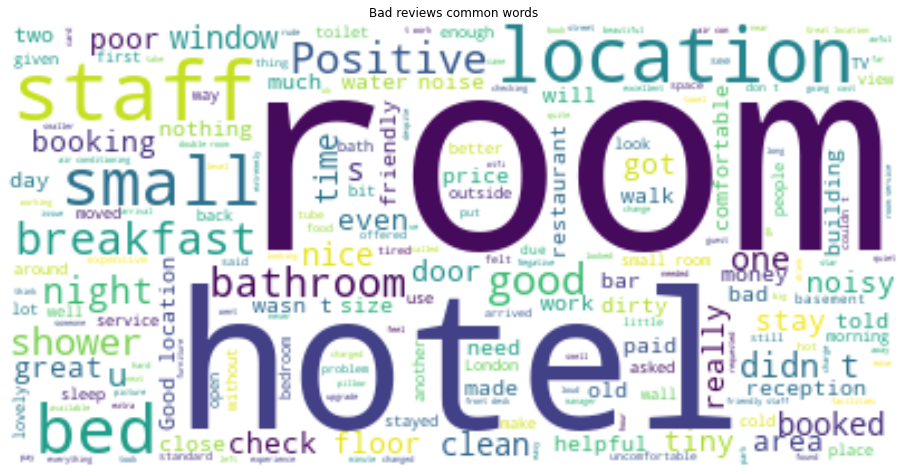

In [48]:
show_word_cloud(bad_reviews_cloud, "Bad reviews common words")

In [49]:
good_df = good_reviews.sample(n=len(bad_reviews), random_state=1234)
bad_df = bad_reviews

In [50]:
review_df = good_df.append(bad_df).reset_index(drop=True)
review_df.shape

C:\Users\Akshay\AppData\Local\Temp\ipykernel_2236\2376158853.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  review_df = good_df.append(bad_df).reset_index(drop=True)


(2070, 2)

In [51]:
review_df.head()

,review,review_type
0,No Negative Great stay Gave us chocolates for ...,good
1,Building work during the day but this can t b...,good
2,The work being done externally right now is o...,good
3,No Negative Clean tidy Good value for money Wo...,good
4,No Negative Good hotel in excellent location f...,good


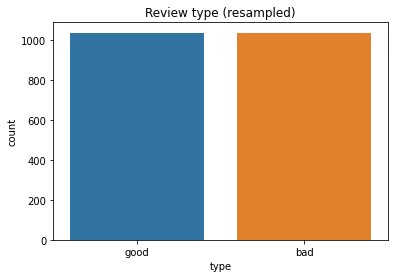

In [52]:
sns.countplot(
  x='review_type',
  data=review_df,
  order=review_df.review_type.value_counts().index
)

plt.xlabel("type")
plt.title("Review type (resampled)");

In [53]:
from operator import imod
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

type_one_hot = OneHotEncoder(sparse=False).fit_transform(
  review_df.review_type.to_numpy().reshape(-1, 1)
)

In [54]:
train_reviews, test_reviews, y_train, y_test =\
  train_test_split(
    review_df.review, 
    type_one_hot, 
    test_size=.1, 
    random_state=1234
  )

In [55]:
from tqdm import tqdm
import tensorflow as tf

X_train = []
for r in tqdm(train_reviews):
  emb = use(r)
  review_emb = tf.reshape(emb, [-1]).numpy()
  X_train.append(review_emb)

X_train = np.array(X_train)

100%|██████████| 1863/1863 [01:53<00:00, 16.35it/s]


In [56]:
from tqdm import tqdm
import tensorflow as tf

X_test = []
for r in tqdm(test_reviews):
  emb = use(r)
  review_emb = tf.reshape(emb, [-1]).numpy()
  X_test.append(review_emb)

X_test = np.array(X_test)

100%|██████████| 207/207 [00:13<00:00, 15.89it/s]


In [57]:
print(X_train.shape, X_test.shape)

(1863, 512) (207, 512)


In [58]:
model = keras.Sequential()

model.add(keras.layers.Dense(
    units=256,
    input_shape=(X_train.shape[1], ),
    activation='relu'
))

model.add(
    keras.layers.Dense(
        units=128,
        activation='relu'
    )
)

model.add(
    keras.layers.Dropout(rate=0.5)
)

model.add(
    keras.layers.Dense(
        units=2,
        activation='softmax'
    )
)

model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(0.001),
    metrics=['accuracy']
)

In [59]:
history = model.fit(X_train, y_train, epochs=10, batch_size=16, validation_split=0.1, verbose=1, shuffle=True)

Epoch 1/10
105/105 [==============================] - 1s 6ms/step - loss: 0.5511 - accuracy: 0.7202 - val_loss: 0.5001 - val_accuracy: 0.7594
Epoch 2/10
105/105 [==============================] - 0s 4ms/step - loss: 0.4345 - accuracy: 0.7846 - val_loss: 0.4865 - val_accuracy: 0.7914
Epoch 3/10
105/105 [==============================] - 0s 4ms/step - loss: 0.3852 - accuracy: 0.8305 - val_loss: 0.4636 - val_accuracy: 0.8021
Epoch 4/10
105/105 [==============================] - 0s 4ms/step - loss: 0.3335 - accuracy: 0.8473 - val_loss: 0.4793 - val_accuracy: 0.7594
Epoch 5/10
105/105 [==============================] - 0s 4ms/step - loss: 0.2742 - accuracy: 0.8902 - val_loss: 0.5231 - val_accuracy: 0.7594
Epoch 6/10
105/105 [==============================] - 0s 4ms/step - loss: 0.1946 - accuracy: 0.9385 - val_loss: 0.5854 - val_accuracy: 0.7594
Epoch 7/10
105/105 [==============================] - 0s 4ms/step - loss: 0.1234 - accuracy: 0.9612 - val_loss: 0.6848 - val_accuracy: 0.7540
Epoch 

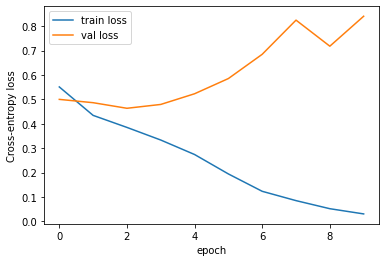

In [60]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel("epoch")
plt.ylabel("Cross-entropy loss")
plt.legend();

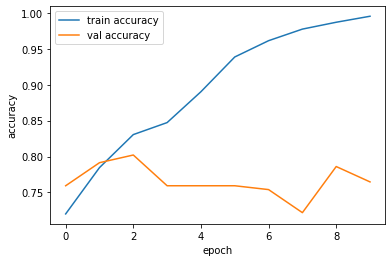

In [61]:
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel("epoch")
plt.ylabel("accuracy")
plt.legend();

In [62]:
model.evaluate(X_test, y_test)

7/7 [==============================] - 0s 3ms/step - loss: 0.7298 - accuracy: 0.7971


[0.7297770977020264, 0.7971014380455017]

In [63]:
print(test_reviews.iloc[0])
print("Bad" if y_test[0][0] == 1 else "Good")

 Not applicable Everything was fine  General approach is friendly but also efficient 
Good


In [64]:
y_pred = model.predict(X_test[:1])
print(y_pred)
"Bad" if np.argmax(y_pred) == 0 else "Good"

1/1 [==============================] - 0s 87ms/step
[[3.0191982e-04 9.9969816e-01]]


'Good'